# Data Cleaning and EDA

### Import packages and data


In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# from xgboost import XGBClassifier
import seaborn as sns

In [2]:
#import training data 
df_train = pd.read_csv('../../../data/raw/train_set_values.csv')
df_labels = pd.read_csv('../../../data/raw/train_set_labels.csv')

#merge labels and features:
df_train= pd.merge(df_train, df_labels, on='id')


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


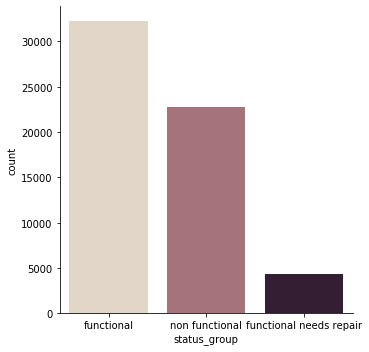

In [4]:
#check the target classes counts:
print(df_train.status_group.value_counts())
sns.catplot(x="status_group", kind="count", palette="ch:.25", data=df_train)

Seems like 'functional' and 'non-functional' are almost balanced enough.... but 'functional needs repair' has a big class inbalance. We'll need to address this later at some point in time... maybe through upsampling, or maybe we could just lump it into non-functional. 

### Clean NaN Values

In [5]:
#find out which features have NAN values. 
df_train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

There are many features with NaN values. We'll need to address each of these on a case by case basis as far as what we want to do with the empty values. 

In [6]:
#start with 'scheme_name' since there are so many empty values. 
print(len(df_train.scheme_name.value_counts()))
df_train.scheme_name.value_counts()

2696


K                            682
None                         644
Borehole                     546
Chalinze wate                405
M                            400
                            ... 
Mtunguruzi                     1
LENCH TARAMAI                  1
Mradi wa maji wa Ndongosi      1
Mondoros water scheme          1
Kalemela Mwaloni               1
Name: scheme_name, Length: 2696, dtype: int64

In [7]:
#According to the feature descriptions this is the same
#as scheme_management, so lets check this:
print(len(df_train.scheme_management.value_counts()))
df_train.scheme_management.value_counts()

12


VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

Ok, scheme_name and scheme_management seem to be different, but because there are over 2669 values for scheme_name and there are 28166 missing values, droping that column will likely not reduce in any loss in predictive power. 

In [8]:
df_train = df_train.drop('scheme_name', axis=1)

In [9]:
#functions to aid in data cleaning

def values_to_keep(df, column, number_of_values_to_keep, verbose = False):
    """
    This function takes in a pandas dataframe, the column of concern, and a number of categories to reduce the number 
    of unique values to. It prints the number of unique values in the column and the top value counts of each. It also
    returns a list of categorical values to retain. 
    """
    number_of_values_to_keep = number_of_values_to_keep-1
    
    if verbose == True:
        print(len(df[column].value_counts()))
        print(df[column].value_counts())
        
        list_of_values = df[column].value_counts()
        list_of_values_to_keep = list(list_of_values[0:number_of_values_to_keep].index)
    else:
        
        list_of_values = df[column].value_counts()
        list_of_values_to_keep = list(list_of_values[0:number_of_values_to_keep].index)
        
    return list_of_values_to_keep

def reduce_categorical_values(df, column_name, number_of_values_to_keep):
    
    """
    This function reduces the number of unique categorical values in a specific dataframe's column. It keeps the top 
    'number_of_values_to_keep' values, and casts the other remaining categorical values as "Other". This function 
    returns a Dataframe with the altered categorical values. Using this function can reduce the amount of dummy columns
    needed whilst maintaining the information contained in the column.
    """
    #use helper function to create a list of cat. values to keep
    list_of_classes_to_keep = values_to_keep(df, column_name, number_of_values_to_keep)
    
    #use subsetting to test if cat. value is in list, if not cast it to 'Other'    "~" means isNOTin 
    df[column_name].loc[~df[column_name].isin(list_of_classes_to_keep)]='Other'
    
    return df

def plot_feature(df, pred_col, target_variable, height = 10):
    
    """
    Produces a categorical bar plot visualizing the number of observations in each target category for each predicitve 
    value. 
    """
    
    sns.catplot(y=pred_col, hue=target_variable, kind="count",
            palette="ch:.25", edgecolor=".6",
            data=df, height= height); 

# def reduce_categorical_values(df, column_name, number_of_values_to_keep):
    
#     """
#     This function reduces the number of unique categorical values in a specific dataframe's column. It keeps the top 
#     'number_of_values_to_keep' values, and casts the other remaining categorical values as "Other". This function 
#     returns a Dataframe with the altered categorical values.
#     """
#     list_of_classes_to_keep = values_to_keep(df, column_name, number_of_values_to_keep)
#     for value in df[column_name].unique():
#         if value in list_of_classes_to_keep:
#             pass
#         else:
#             df.loc[df[column_name]== value]="Other"
#     return df


In [10]:
#ok, now lets check the rest in descending order starting with 'funder':
#Lets find the number of categorical values in 'funder', and the top 10 values:
values_to_keep(df_train, 'funder', 10, verbose=True)

1897
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Godii                        1
Matata Selemani              1
Upendo Primary School        1
Mzee Ngwatu                  1
Municipal Council            1
Name: funder, Length: 1897, dtype: int64


['Government Of Tanzania',
 'Danida',
 'Hesawa',
 'Rwssp',
 'World Bank',
 'Kkkt',
 'World Vision',
 'Unicef',
 'Tasaf']

'funder' has 1897 unique categories, ~3000 NaN values, but clearly the majority of the water pumps come from a few of the different funders. it doesnt seem right to just fill the NaNs with the mode. There are also way to many to OneHotEncode. Lets instead turn it into 10 categories: the top 9 frequently occuring values,  and one "other" category which will include all other categories + the NaN values.

In [11]:
reduce_categorical_values(df_train, 'funder', 10)

/Users/brentsair/anaconda3/envs/tanz-water/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Other,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Other,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Other,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Other,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Other,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,2011-05-07,Other,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,2011-04-11,Other,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03-08,Other,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


10
Other                     37810
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef                     1057
Tasaf                       877
Name: funder, dtype: int64


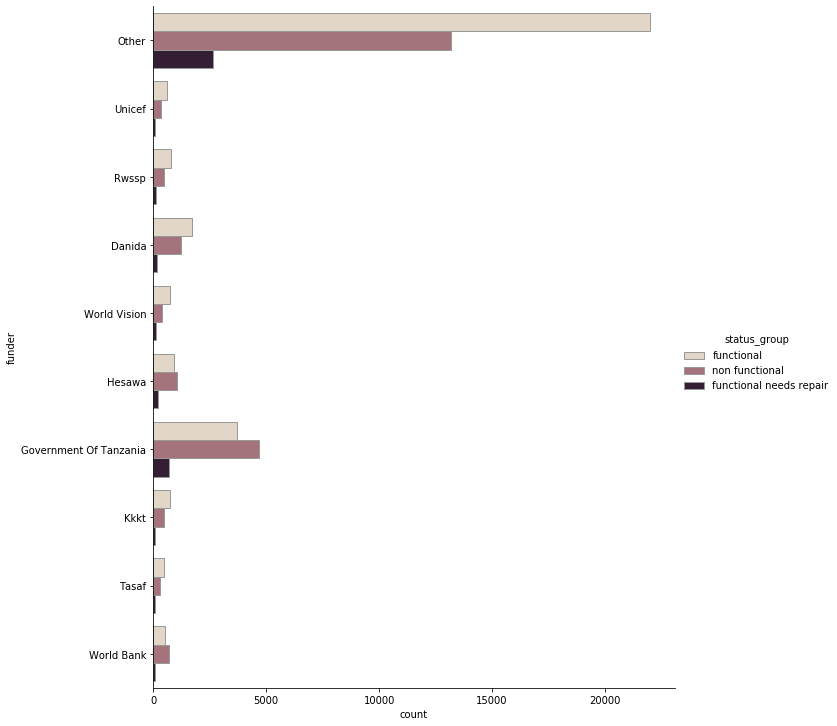

In [12]:
print(len(df_train.funder.value_counts()))
print(df_train.funder.value_counts())
plot_feature(df_train, 'funder', 'status_group')

Looking at the above chart, it seems like funder could be a good predictor sice there are particular funders with significant numbers of disfunctional pumps.  

In [13]:
#Now for 'installer'.Lets find the number of categorical values in 'installer', and the top 10 values:
values_to_keep(df_train, 'installer', 10, verbose= True)


2145
DWE                     17402
Government               1825
RWE                      1206
Commu                    1060
DANIDA                   1050
                        ...  
George mtoto company        1
Elina                       1
TCRS/ TWESA                 1
IN                          1
world vision                1
Name: installer, Length: 2145, dtype: int64


['DWE', 'Government', 'RWE', 'Commu', 'DANIDA', 'KKKT', 'Hesawa', '0', 'TCRS']

In [14]:
#reduce the categorical values of 'installer' to 10, and fill NaN values:
df_train = reduce_categorical_values(df_train, 'installer', 10)

10
Other         33635
DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
KKKT            898
Hesawa          840
0               777
TCRS            707
Name: installer, dtype: int64


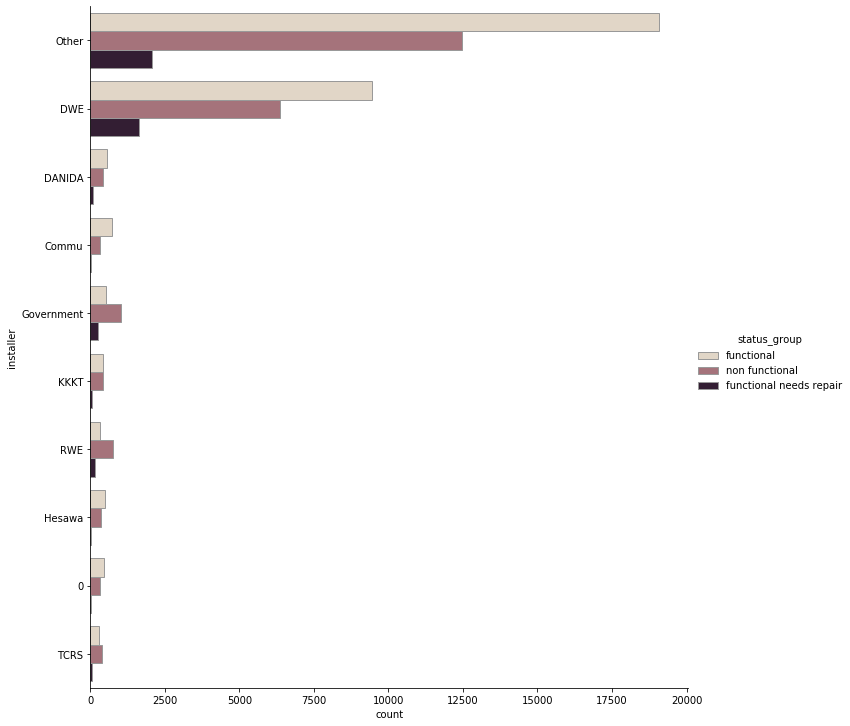

In [15]:
print(len(df_train.installer.value_counts()))
print(df_train.installer.value_counts())
plot_feature(df_train, 'installer', 'status_group')

Looks like installer could be a useful predictor as well! Look at 'Goverment' and 'RWE'. 

In [16]:
#Now for 'subvillage'. Lets find the number of categorical values in 'subvillage', and the top 10 values:
values_to_keep(df_train, 'subvillage', 10, verbose= True)

19287
Madukani           508
Shuleni            506
Majengo            502
Kati               373
Mtakuja            262
                  ... 
Mnyongo              1
Nyameni              1
Lulemba              1
Aicho Kaskazini      1
Barjomot             1
Name: subvillage, Length: 19287, dtype: int64


['Madukani',
 'Shuleni',
 'Majengo',
 'Kati',
 'Mtakuja',
 'Sokoni',
 'M',
 'Muungano',
 'Mbuyuni']

Over 19000 various values! And the top 10 do not seem to have a significant amount of the total distribution, therfore it is highly unlikely that any one of these is great predictor, but just in case lets check the distribution of the top 10. 

10
Other       56494
Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
Sokoni        232
M             187
Muungano      172
Mbuyuni       164
Name: subvillage, dtype: int64


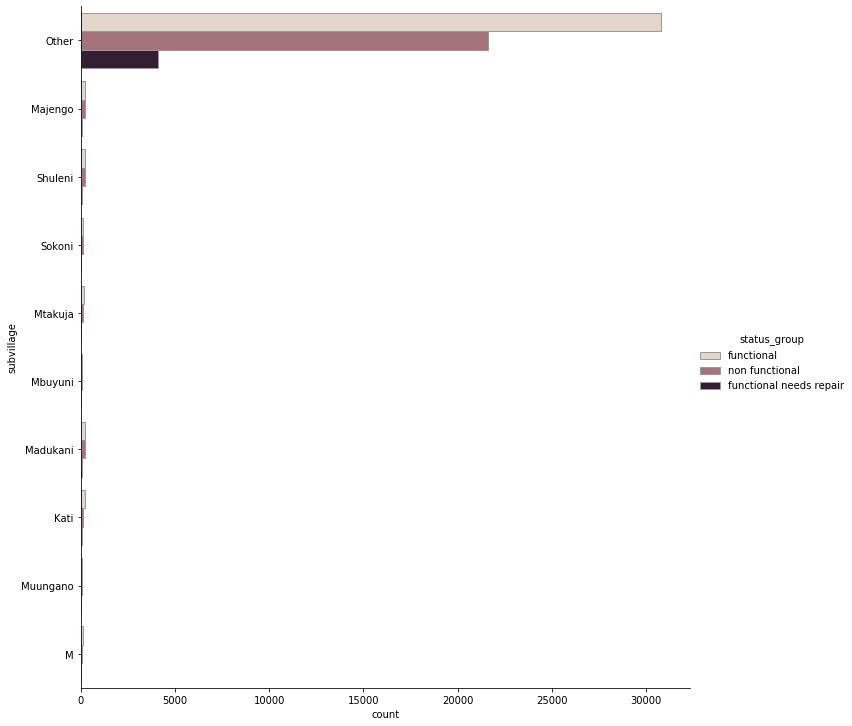

In [17]:
reduce_categorical_values(df_train, 'subvillage', 10)
print(len(df_train.subvillage.value_counts()))
print(df_train.subvillage.value_counts())
plot_feature(df_train, 'subvillage', 'status_group')

Because none of the top 10 villages (not counting 'other') have an overwhelming majority of functioning/nonfunctioning this confirms the previous assumption, the subvillage value is likely to be a poor predictor so we can just drop it.  

In [18]:
df_train = df_train.drop('subvillage', axis=1)

In [19]:
#Now for 'public_meeting'. Lets find the number of categorical values in 'public_meeting'.
values_to_keep(df_train, 'public_meeting', 10, verbose= True)

2
True     51011
False     5055
Name: public_meeting, dtype: int64


[True, False]

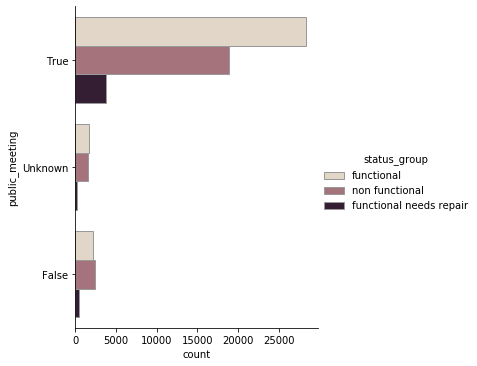

In [20]:
#Replace NaN values with "Unknown" and visualize the predictor's distribution
df_train.public_meeting.fillna(value='Unknown', inplace=True)
plot_feature(df_train, 'public_meeting', 'status_group', height=5)

In [21]:
#Now for 'scheme_management'. Lets find the number of categorical values in 'scheme_management'.
values_to_keep(df_train, 'scheme_management', 10, verbose= True)

12
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64


['VWC',
 'WUG',
 'Water authority',
 'WUA',
 'Water Board',
 'Parastatal',
 'Private operator',
 'Company',
 'Other']

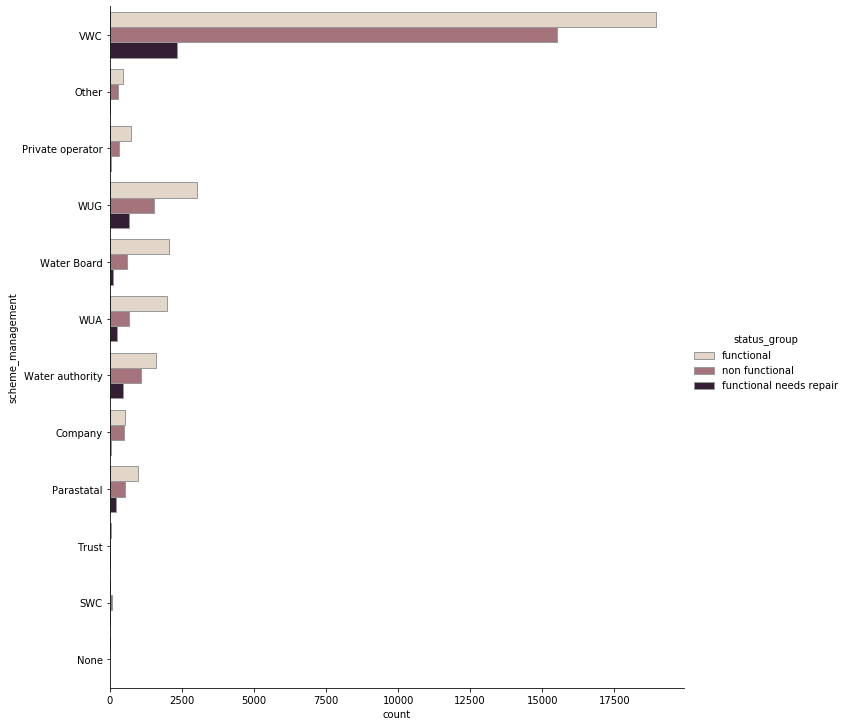

In [22]:
plot_feature(df_train, 'scheme_management', 'status_group')

Because the 10th most frequent value has mostly "non-functioning" wells, it could be a specific and precise predictor. Lets keep it. So, we'll reduce the number of values to 11, and fill in the ~3000 NaN values. 

11
VWC                 36793
WUG                  5206
Other                4644
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64


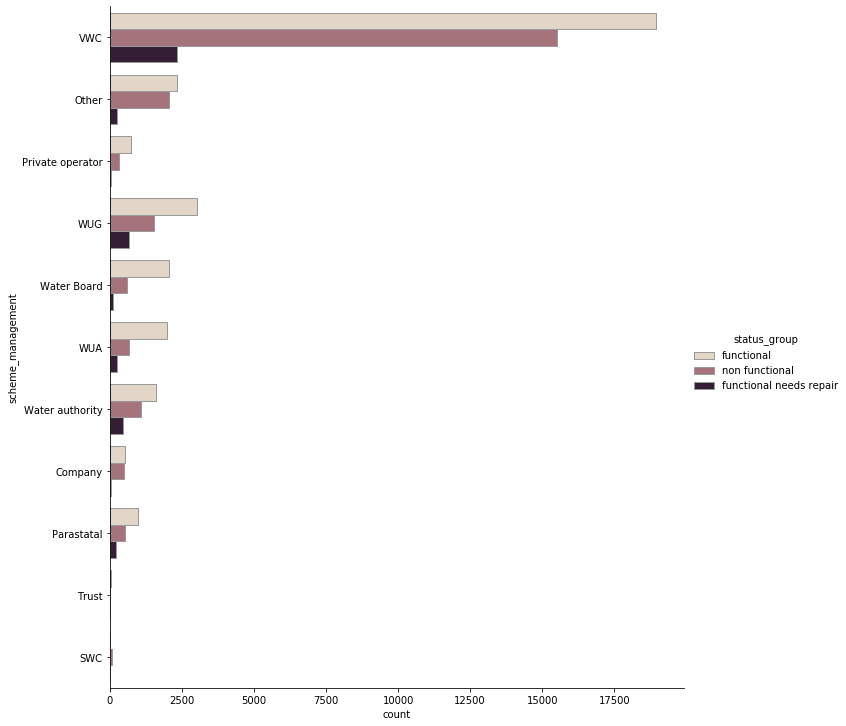

In [23]:

reduce_categorical_values(df_train, 'scheme_management', 12)
print(len(df_train.scheme_management.value_counts()))
print(df_train.scheme_management.value_counts())
plot_feature(df_train, 'scheme_management', 'status_group')

In [24]:
#Now for 'permit'. Lets find the number of categorical values in 'permit':
values_to_keep(df_train, 'permit', 10, verbose= True)

2
True     38852
False    17492
Name: permit, dtype: int64


[True, False]

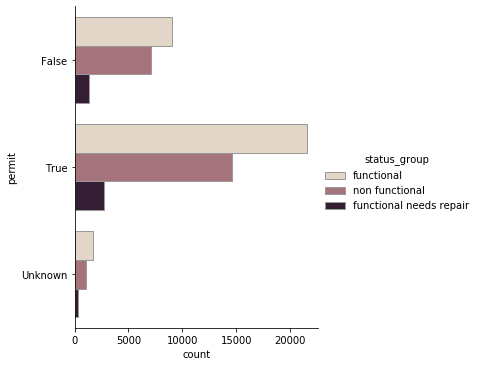

In [25]:
#Another boolean valued category. Let's replace the NaN with 'Unknown'
df_train.permit.fillna(value='Unknown', inplace=True)
plot_feature(df_train, 'permit', 'status_group', height=5)

In [26]:
df_train.isnull().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
w

Great, no more NaN values. Moving on!
